In [1]:
import sys
sys.path.append('C:/QCodes drivers and scripts/Drivers')

from PLH250P_current_source_dummy import TTi
from PLH250P_current_source_TCP import current_set,power_up as current_source_on,power_down as current_source_off
current_source = TTi('TTi')

import VNA_Anritsu as VNA_Anritsu
vna_gain= VNA_Anritsu.MS46522B('VNA', 'TCPIP::192.168.0.52',  init_s_params=False)
vna_gain.add_channel('S21')

from RS_SMB_100A import SMB100A
MW_source_1_gain = SMB100A('SMB100A_1', 'TCPIP0::192.168.0.53::inst0::INSTR')
# MW_source_2_gain = SMB100A('SMB100A_2', 'TCPIP0::192.168.0.54::inst0::INSTR')

# from RS_FSQ import RS_FSQ
# RS_SA_gain = RS_FSQ('RS_FSQ', 'TCPIP0::192.168.0.61::inst0::INSTR')

from MW_switch_controller import set_rt_switch,set_cryo_switch

Connected to: Dummy corp current source 001 (serial:dummy 100, firmware:None) in 0.00s
Connected to: ANRITSU MS46522B (serial:1728106, firmware:V2019.12.1,V3.3.12) in 0.09s
Connected to: Rohde&Schwarz SMB100A (serial:1406.6000k03/177960, firmware:3.1.18.2-3.01.203.32) in 0.02s


In [2]:
import sys
import qcodes as qc
from qcodes.logger.logger import start_all_logging
import datetime
from qcodes.dataset.plotting import plot_dataset
import numpy as np
import matplotlib.pyplot as plt
#qcodes.config.subscription.default_subscribers = ["Plottr"]
from time import sleep

from pprint import pprint
import json

sys.path.append('C:\QCodes drivers and scripts\Scripts\Arpit\Modules')
from notify import snotify
from progress_bar import bar

In [3]:
import matplotlib
# %matplotlib notebook
%matplotlib inline

In [4]:
start_all_logging()

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\nicolas.roch\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\nicolas.roch\.qcodes\logs\220601-18048-qcodes.log


In [5]:
#create a station
station = qc.Station()
station.add_component(vna_gain)
station.add_component(current_source)
station.add_component(MW_source_1_gain)
# station.add_component(MW_source_2_gain)
# station.add_component(RS_SA_gain)
station.snapshot()
station.components

{'VNA': <MS46522B: VNA>, 'TTi': <TTi: TTi>, 'SMB100A_1': <SMB100A: SMB100A_1>}

In [6]:
# Load experiment details
experiment_file = open('C:\QCodes drivers and scripts\Scripts\Arpit\_experiment_details.json','r')
experiment = experiment_file.readlines()
experiment=json.loads(''.join(experiment))

user = experiment['details']['user']
# date = experiment['details']['date']
date = '-'.join(str(datetime.date.today()).split('-'))
description = experiment['details']['description']
cooldown = experiment['details']['cooldown']
database_name = date+"_"+'CD_'+cooldown+'_'+user+"_"+description

# print(database_name)
# database_name = '2021-08-31_CD_30_08_LP_TWPA Charac'

#Create or Initialize the database
qc.initialise_or_create_database_at("D:/Data_QCodes/"+database_name)
qc.config.core.db_location

'D:/Data_QCodes/2022-06-01_CD_30_05_GC_GLG_SSH_SPD'

In [7]:
device_ids = experiment['device_ids']

In [11]:
parameter_snap={}

# VNA
start_freq = 3
end_freq = 13
points_per_gigahz = 1000
VNA_power = -10
IF_bandwidth = 100
Averages = 1
points_VNA=1+(end_freq-start_freq)*points_per_gigahz
points_VNA=int(points_VNA)
parameter_snap['vna']={'start_freq':start_freq,'end_freq':end_freq,'points_per_gigahz':points_per_gigahz,'VNA_power':VNA_power,'IF_bandwidth':IF_bandwidth,'Averages':Averages,'points':points_VNA}

# Current source
I = 0.3
parameter_snap['flux']={'I':I}

# MW Source Pump
pump_frequency = 8.1
pump_power = 5.4

parameter_snap['pump']={'pump_frequency':pump_frequency,'pump_power':pump_power}




MW_source_1_gain.frequency(pump_frequency*1e9)
MW_source_1_gain.power(pump_power)
MW_source_1_gain.phase(0)

current_set(I)

vna_gain.channels.S21.bandwidth(IF_bandwidth)
vna_gain.channels.S21.power(VNA_power)
vna_gain.channels.S21.avg(Averages)
vna_gain.channels.npts(points_VNA)
vna_gain.channels.start(start_freq*1e9)
vna_gain.channels.stop(end_freq*1e9)


# Initialize devices and measurement
vna_gain.rf_on()
vna_gain.cont_meas_on()

experiment_file = open('C:\QCodes drivers and scripts\Scripts\Arpit\_experiment_details.json','r')
experiment = experiment_file.readlines()
experiment = json.loads(''.join(experiment))
switch_position = experiment['current_device']['current_device']
sample_name = device_ids[switch_position]

# states = ['off','on']
states = ['on']
for pump in states:
    
    exp_name = 'Gain : pump '#+str(pump)

    exp=qc.load_or_create_experiment(experiment_name=exp_name,
                              sample_name=sample_name)

    meas = qc.Measurement(exp=exp, station=station) 
    meas.register_parameter(vna_gain.channels.S21.trace_mag_phase) 
    meas.write_period = 10
    
    MW_source_1_gain.status(pump)

    with meas.run() as datasaver:
        get_v = vna_gain.channels.S21.trace_mag_phase.get()
        datasaver.add_result((vna_gain.channels.S21.trace_mag_phase, get_v))

    id_num=datasaver.dataset.run_id
    qc.load_by_run_spec( captured_run_id=id_num).add_metadata('parameter_snap',json.dumps(parameter_snap))

Starting experimental run with id: 11. 


In [8]:
captured_run_id_off = 1
captured_run_id_on = 2
# captured_run_id_on = captured_run_id_off + 1
dataset_off = qc.load_by_run_spec(captured_run_id=captured_run_id_off)
dataset_on = qc.load_by_run_spec(captured_run_id=captured_run_id_on)
mag_off = dataset_off.get_parameter_data('magnitude')['magnitude']['magnitude']
mag_on = dataset_on.get_parameter_data('magnitude')['magnitude']['magnitude']
freq_data = dataset_off.get_parameter_data('magnitude')['magnitude']['VNA_S21_S21_frequency']*1e-9
exp_name = dataset_on.exp_name
sample_name = dataset_on.sample_name
meta = json.loads(dataset_on.get_metadata('parameter_snap'))
start_freq = meta['vna']['start_freq']
end_freq = meta['vna']['end_freq']
points_per_gigahz = meta['vna']['points_per_gigahz']
VNA_power =  meta['vna']['VNA_power']
I =  meta['flux']['I']
# pprint(dataset_on.metadata['parameter_snap'])

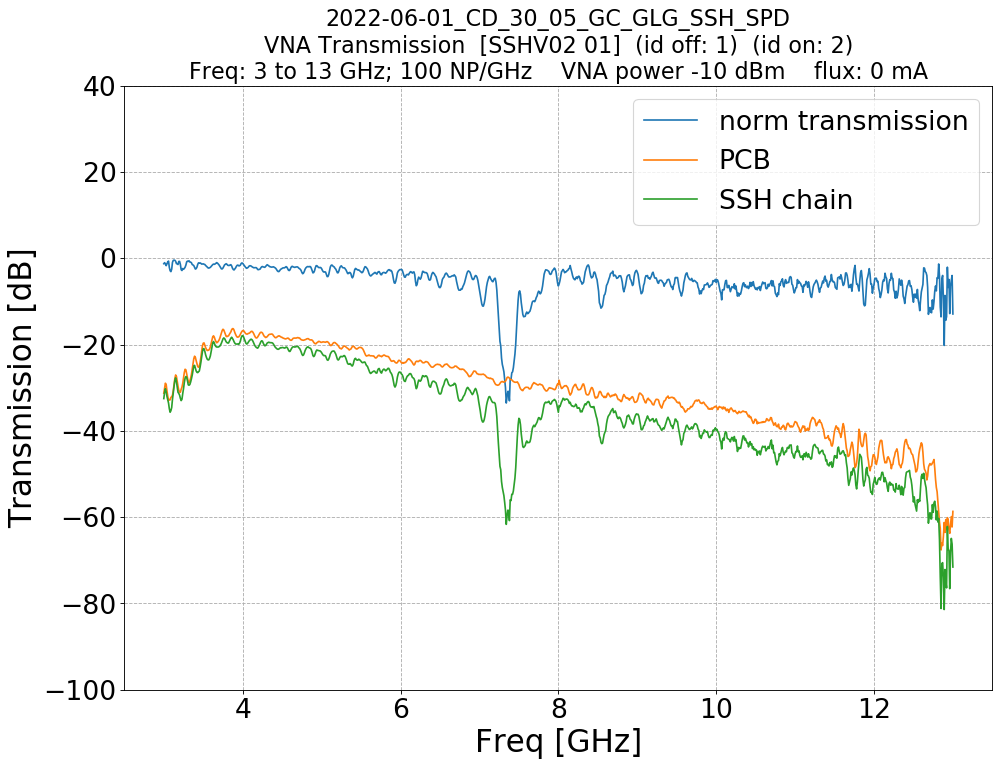

In [12]:
plot_title = database_name+'\n'+exp_name.split(':')[0]+'  ['+sample_name+']  (id off: '+str(captured_run_id_off)+')  (id on: '+str(captured_run_id_on)
plot_title+=')\nFreq: '+str(start_freq)+' to '+str(end_freq)+' GHz; '+str(points_per_gigahz)+' NP/GHz    VNA power '+str(VNA_power)+' dBm    flux: '+str(I)+' mA'
# plot_title+='\n pump freq: '+str(pump_frequency)+' GHz Pump power: '+ str(pump_power)+' dBm'


plt.figure(figsize=(14, 10), dpi= 80) #facecolor='w', edgecolor='k'
x_label='Freq [GHz]'
# x_label='Freq [MHz]'

y_label='Transmission [dB]'

plt.rc('axes', labelsize=10*2)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12*2)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12*2)    # fontsize of the tick labels
plt.rc('grid', linestyle="--")
plt.grid(True)


# plt.plot(freq_data,mag_on-mag_off,label='gain')
# plt.plot(freq_data,mag_off,label='pump off')
# plt.plot(freq_data,mag_on,label='pump on')

plt.plot(freq_data,mag_on-mag_off,label='norm transmission')
plt.plot(freq_data,mag_off,label='PCB')
plt.plot(freq_data,mag_on,label='SSH chain')
    
plt.xlabel(x_label, size=14*2)
plt.ylabel(y_label, size=14*2)
plt.title(plot_title, size=20)

# plt.xlim(2,5)
plt.ylim(-100,40)

plt.legend(fontsize = 12*2)
plt.show()    

In [21]:
np.set_printoptions(threshold=sys.maxsize)

In [44]:
np.save("pumpon.npy", mag_on)